In [3]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
!pip install matplotlib 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 获取CIFAR-10 dataset

CIFAR-10 是一个用于对象识别的经典数据集，由 Alex Krizhevsky、Vinod Nair 和 Geoffrey Hinton 收集。

它的特点可以概括为 "10-60000-32"：

10 类物体：包含飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船、卡车。

60,000 张图片：其中 50,000 张用于训练，10,000 张用于测试。

32×32 分辨率：图片非常小（彩色 RGB），这使得它对电脑配置要求不高，非常适合初学者练手。

In [4]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),    # 先在图片周围填充4个像素，再随机裁剪回 $32 \times 32$。这像是在教模型：“即使物体位置稍微偏了一点，你也要认得它。”
        RandomHorizontalFlip(),   # 随机水平翻转图片。告诉模型：“左边的猫和右边的猫都是猫。”
        ToTensor(),   # 它把图片的像素值（0-255）缩放到 $0.0$ 到 $1.0$ 之间，并将图片格式从 HWC（高、宽、通道）转换为 PyTorch 喜欢的 CHW（通道、高、宽）张量格式。
    ]),
    "test": ToTensor(),
}
# 数据集
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],    # transform参数是对图片进行的预处理
  )
# 数据加载器
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,   # 每次给模型“喂” 512 张图片。
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170M/170M [00:07<00:00, 22.6MB/s] 


## 定义模型

定义模型框架

In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))    # OrderedDict(layers) 的作用就是把这个列表转换成一个有序字典。PyTorch 的 nn.Sequential 如果接收到一个 OrderedDict，它就会使用字典里的 Key 作为这一层的名字，而不是用默认的数字编号。
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    '''将url中的内容下载到指定model_dir下, 命名为文件本身名称'''
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

加载模型参数

In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])     # 一个匿名函数，recover_model()即可将模型参数恢复初始状态

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


## 评估初始化时模型的准确度和模型大小

评估函数

In [9]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

获取模型大小函数

In [11]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [12]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


## 查看weight values的分布

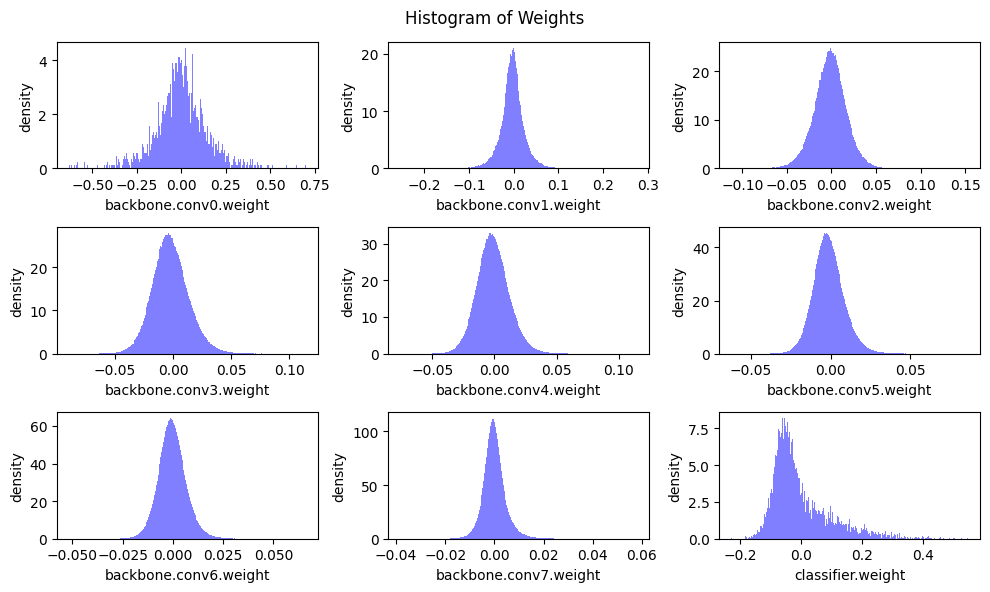

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:     # 维度大于 1 的通常是卷积核权重或全连接层权重。维度等于 1 的通常是偏置（Bias）或 BatchNorm 的参数。我们显然只想看核心权重的分布。
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()       # 将参数拉伸为1维，并加载到cpu上
                param_cpu = param_cpu[param_cpu != 0].view(-1)  # 去除参数值为0的值
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,     # density=True 则直方图y轴为概率密度(图面积大小和为1)
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

观察到大量weight values为0, 可以对这些weight values为0的weight进行pruning

## Fine-grained Pruning 细粒度剪枝

**原理**

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.
 **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. 

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor: 将tensor的稀疏度变为指定的稀疏度, 并返回mask(Tensor类型, 为原Tensor中值变为0后的位置)
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round()) 我认为这里的意思其实让我们计算tensor进行剪枝后要变成0的元素个数
    num_zeros = round(sparsity * num_elements)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    # # torch.kthvalue(input, k, dim=None, keepdim=False, *, out=None)
    # Returns a namedtuple (values, indices) where values is the k th smallest element of 
    # each row of the input tensor in the given dimension dim. 
    # And indices is the index location of each element found.
    threshold = torch.kthvalue(importance.view(-1), num_zeros)[0]   # 注意其是在整个tensor中找到能够使得tensor有num_zeros个0值的阀值
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    # torch.gt(input, other, *, out=None) → Tensor
    mask = torch.gt(importance, threshold)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

测试`fine_grained_prune`函数正确性

In [24]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

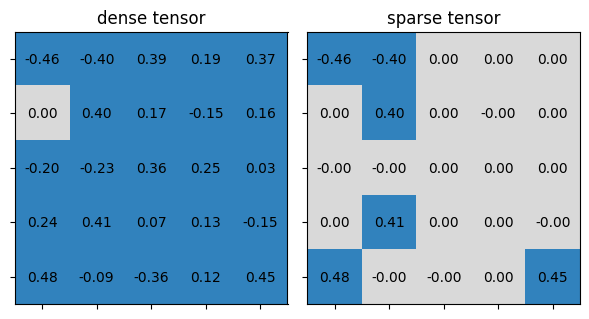

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [25]:
test_fine_grained_prune()

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

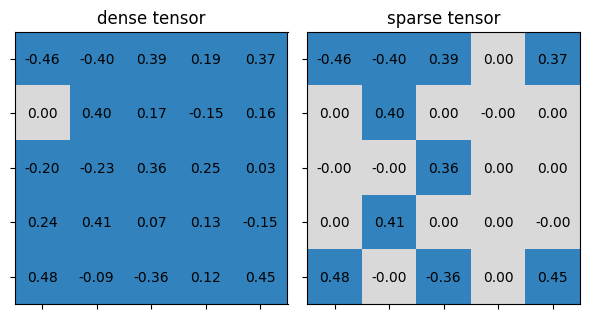

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [27]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = (25 - 10) / 25 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

### 将Fine-grained Pruning运用于整个模型

如上代码`fine_grained_prune`只是将指定tensor的稀疏度转变成指定稀疏度，我们要将此方法运用于整个model

其中方法也很简单，因为整个model的每一层就是由weight组成，weight就是tensor

同时我们希望记录稀疏之后各个weight稀疏的位置(即各个weight的mask)

In [29]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## 如何决定model各层weight的稀疏度 -- Sensitivity Scan

此方法简单来说就是对每一层weight尝试不同的稀疏度，运行模型测试accuracy, 记录accuracy vs. sparsity的sensitivity curve

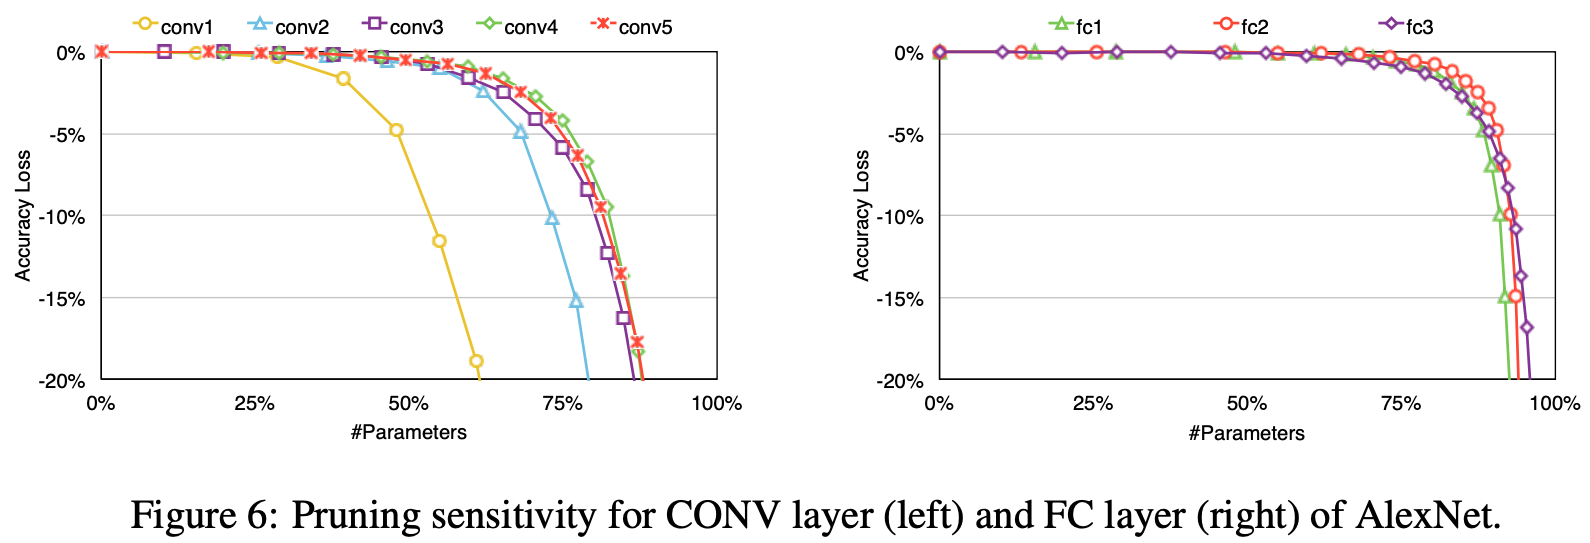

In [30]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    ''' 稀疏度从scan_start开始到scan_end进行测试, 每次稀疏度stride为scan_step
    '''
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)   # param.detach() 产生的张量与原始 param 共享内存。你在 detach 后的张量上剪枝，原始模型的权重也会受到影响。
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies 

In [31]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.43%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.82%, 92.97%, 92.67%, 92.52%]

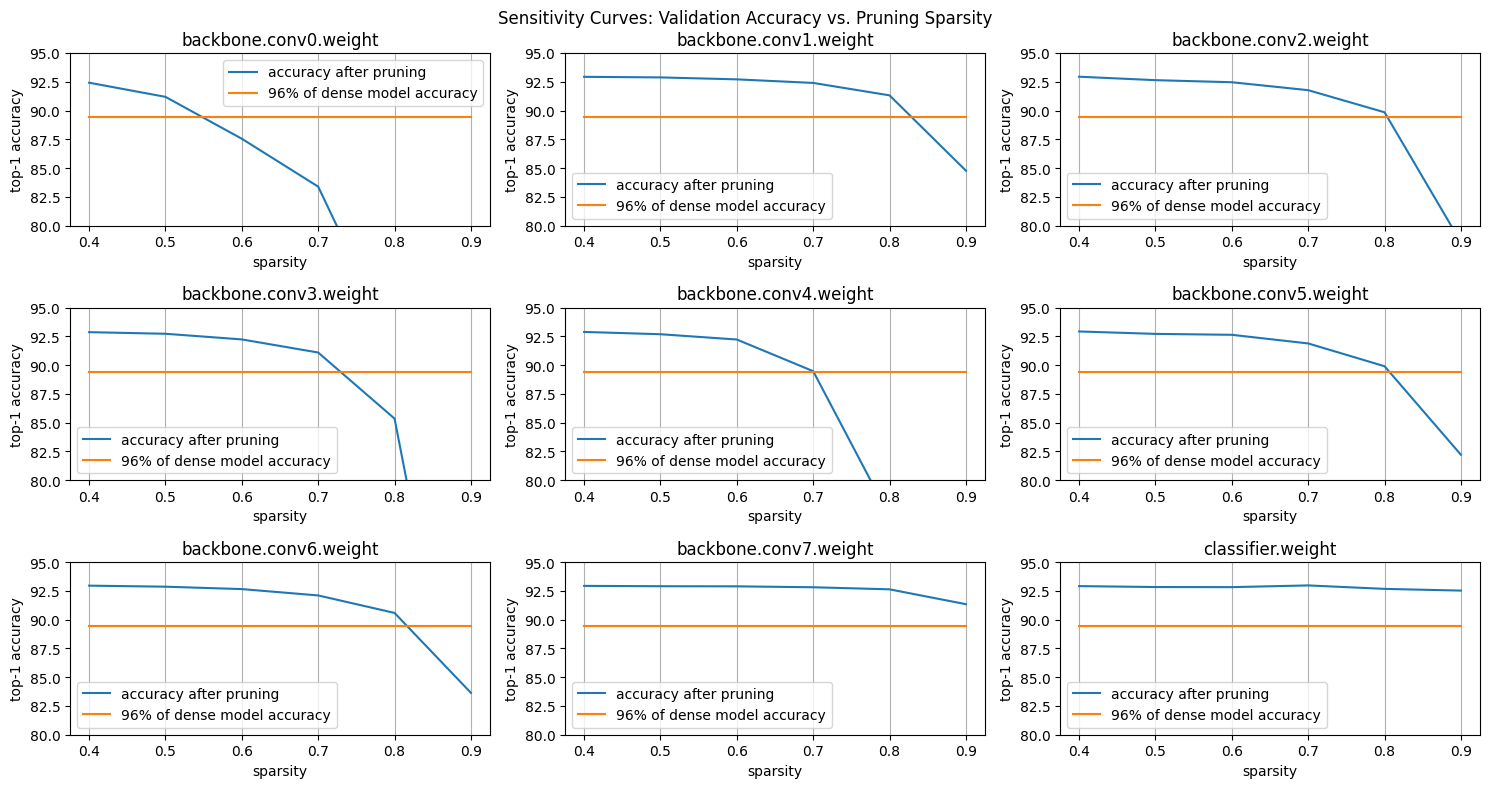

In [32]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)